# ProtT5 models fine-tuning with LoRA for Antimicrobial Peptides (AMP) Classification

## Overview
This notebook demonstrates the process of:
1. Fine-tuning ProtT5 models with Low-Rank Adaptation (LoRA) to perform AMP classification (AMP vs non-AMP ).
2. Evaluating the model's performance using metrics such as accuracy, precision, recall, F1-score, ROC AUC, and Matthews correlation coefficient (MCC).

## Acknowledgment

The implementation of Low-Rank Adaptation (LoRA) and the model adaptation code used in this notebook have been adapted from the work by Robert Schmirler et al. The original repository can be found at:

- [GitHub Repository: PLM Fine-Tuning Evaluation](https://github.com/RSchmirler/data-repo_plm-finetune-eval)


In [ ]:
# Install dependencies
!pip install datasets evaluate==0.4.0 biopython datasets wandb transformers peft
!pip install -U bitsandbytes accelerate

In [ ]:
# Import necessary libraries

import os.path
from Bio import SeqIO
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import BCEWithLogitsLoss, CrossEntropyLoss, MSELoss
import re
import numpy as np
import pandas as pd
import copy
import transformers, datasets
from transformers.modeling_outputs import SequenceClassifierOutput
from transformers.models.t5.modeling_t5 import T5Config, T5PreTrainedModel, T5Stack
from transformers.utils.model_parallel_utils import assert_device_map, get_device_map
from transformers import T5EncoderModel, T5Tokenizer
from transformers import TrainingArguments, Trainer, set_seed
from peft import get_peft_config, PeftConfig, inject_adapter_in_model, LoraConfig
from evaluate import load
from datasets import Dataset
import random
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score, matthews_corrcoef

## Helper Functions for Data Loading and Processing

In [ ]:
def load_fasta(file_path):
    """
    Load sequences from a FASTA file and return them in a DataFrame.

    Args:
        file_path (str): Path to the FASTA file.

    Returns:
        pd.DataFrame: DataFrame containing 'seq_id' and 'sequence'.
    """
    with open(os.path.abspath(file_path)) as fasta_file:
        seq_ids, sequences = [], []
        for seq_record in SeqIO.parse(fasta_file, "fasta"):
            sequences.append(str(seq_record.seq))
            seq_ids.append(seq_record.id)
    data = pd.DataFrame({"seq_id": seq_ids, "sequence": sequences})
    data.drop_duplicates(inplace=True)
    data.reset_index(drop=True, inplace=True)
    return data

In [ ]:
def preprocess_sequences(data):
    """
    Preprocess sequences by separating letters and replacing invalid characters.

    Args:
        data (pd.DataFrame): DataFrame containing sequences.

    Returns:
        pd.DataFrame: Updated DataFrame with 'Separated' and 'Processed' columns.
    """
    def process_sequence(sequence):
        # Separate letters with spaces and replace invalid characters
        separated = ' '.join(sequence)
        processed = re.sub(r"[UZOB]", "X", separated)
        return separated, processed

    # Apply preprocessing to each sequence
    data[['Separated', 'Processed']] = data['sequence'].apply(
        lambda seq: pd.Series(process_sequence(seq))
    )
    return data


def prepare_dataset_with_preprocessing(amp_fasta, non_amp_fasta):
    """
    Prepare datasets by loading and preprocessing AMP and non-AMP sequences.

    Args:
        amp_fasta (str): Path to the AMP FASTA file.
        non_amp_fasta (str): Path to the non-AMP FASTA file.

    Returns:
        tuple: (data, labels) where:
            - data (pd.DataFrame): Contains seq_id, sequence, Separated, and Processed columns.
            - labels (list of int): Binary labels (1 for AMP, 0 for non-AMP).
    """
    amp_data = load_fasta(amp_fasta)
    non_amp_data = load_fasta(non_amp_fasta)

    # Preprocess the sequences
    amp_data = preprocess_sequences(amp_data)
    non_amp_data = preprocess_sequences(non_amp_data)

    # Combine data and create labels
    data = pd.concat([amp_data, non_amp_data], ignore_index=True)
    labels = [1] * len(amp_data) + [0] * len(non_amp_data)

    return data, labels

### Data Preparation
Loading and processing training and test datasets.


In [ ]:
# File paths for training and validation data

# Train datasets
train_amp_fasta = "/path/to/your/folder/DRAMP_pretrain_train_positive.fasta"
train_non_amp_fasta = "/path/to/your/folder/DRAMP_pretrain_train_negative.fasta"

# Validation datasets
val_amp_fasta = "/path/to/your/folder/DRAMP_pretrain_val_positive.fasta"
val_non_amp_fasta = "/path/to/your/folder/DRAMP_pretrain_val_negative.fasta"

# Test datasets
test_amp_fasta = "/path/to/your/folder/DRAMP_AMP.fasta"
test_non_amp_fasta = "/path/to/your/folder/DRAMP_nonAMP.fasta"

In [ ]:
# Prepare datasets
train_sequences, train_labels = prepare_dataset_with_preprocessing(train_amp_fasta, train_non_amp_fasta)
validation_sequences, validation_labels = prepare_dataset_with_preprocessing(val_amp_fasta, val_non_amp_fasta)
test_sequences, test_labels = prepare_dataset_with_preprocessing(test_amp_fasta, test_non_amp_fasta)

# Display sample processed data
print("Sample Processed Training Data:")
print(train_sequences.head())

Sample Processed Training Data:
            seq_id                                           sequence  \
0       DRAMP02197  MFTMKKSLLLFFFLGTISLSLCEEERGADEDDGVELTEEEVKRGLL...   
1       AMPfun_779                                       GATPEDLNQKLS   
2        ADAM_1998                       GIMDSVKGLAKNLAGKLLDSLKCKITGC   
3        ADAM_5276                         RFRLPFRRPPIRIHPPPFYPPFRRFL   
4  LAMP_L01A001891     KGLKKDSDFRRVGISVSKKVGKAITRNRVRRLIKEKIKDIVFIKNL   

                                           Separated  \
0  M F T M K K S L L L F F F L G T I S L S L C E ...   
1                            G A T P E D L N Q K L S   
2  G I M D S V K G L A K N L A G K L L D S L K C ...   
3  R F R L P F R R P P I R I H P P P F Y P P F R ...   
4  K G L K K D S D F R R V G I S V S K K V G K A ...   

                                           Processed  
0  M F T M K K S L L L F F F L G T I S L S L C E ...  
1                            G A T P E D L N Q K L S  
2  G I M D S V K G L A K N 

### Key Classes and Functions
- **`ClassConfig`**: Configuration function for model's calssification head.
- **`T5EncoderClassificationHead`**: Custom classification head for ProtT5 models.
- **`T5EncoderForSimpleSequenceClassification`**: Custom ProtT5 encoder model with a classification head.
- **`inject_adapter_in_model`**: LoRA-based parameter adaptation.

In [ ]:
class ClassConfig:
    def __init__(self, dropout=0.2, num_labels=2):
        self.dropout_rate = dropout
        self.num_labels = num_labels

class T5EncoderClassificationHead(nn.Module):
    """Head for sentence-level classification tasks."""

    def __init__(self, config, class_config):
        super().__init__()
        self.dense = nn.Linear(config.hidden_size, config.hidden_size)
        self.dropout = nn.Dropout(class_config.dropout_rate)
        self.out_proj = nn.Linear(config.hidden_size, class_config.num_labels)

    def forward(self, hidden_states):

        hidden_states =  torch.mean(hidden_states,dim=1)  # avg embedding

        hidden_states = self.dropout(hidden_states)
        hidden_states = self.dense(hidden_states)
        hidden_states = torch.tanh(hidden_states)
        hidden_states = self.dropout(hidden_states)
        hidden_states = self.out_proj(hidden_states)
        return hidden_states

In [ ]:
class T5EncoderForSimpleSequenceClassification(T5PreTrainedModel):

    def __init__(self, config: T5Config, class_config):
        super().__init__(config)
        self.num_labels = class_config.num_labels
        self.config = config

        self.shared = nn.Embedding(config.vocab_size, config.d_model)

        encoder_config = copy.deepcopy(config)
        encoder_config.use_cache = False
        encoder_config.is_encoder_decoder = False
        self.encoder = T5Stack(encoder_config, self.shared)

        self.dropout = nn.Dropout(class_config.dropout_rate)
        self.classifier = T5EncoderClassificationHead(config, class_config)

        # Initialize weights and apply final processing
        self.post_init()

        # Model parallel
        self.model_parallel = False
        self.device_map = None

    def parallelize(self, device_map=None):
        self.device_map = (
            get_device_map(len(self.encoder.block), range(torch.cuda.device_count()))
            if device_map is None
            else device_map
        )
        assert_device_map(self.device_map, len(self.encoder.block))
        self.encoder.parallelize(self.device_map)
        self.classifier = self.classifier.to(self.encoder.first_device)
        self.model_parallel = True

    def deparallelize(self):
        self.encoder.deparallelize()
        self.encoder = self.encoder.to("cpu")
        self.model_parallel = False
        self.device_map = None
        torch.cuda.empty_cache()

    def get_input_embeddings(self):
        return self.shared

    def set_input_embeddings(self, new_embeddings):
        self.shared = new_embeddings
        self.encoder.set_input_embeddings(new_embeddings)

    def get_encoder(self):
        return self.encoder

    def _prune_heads(self, heads_to_prune):
        """
        Prunes heads of the model. heads_to_prune: dict of {layer_num: list of heads to prune in this layer} See base
        class PreTrainedModel
        """
        for layer, heads in heads_to_prune.items():
            self.encoder.layer[layer].attention.prune_heads(heads)

    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        head_mask=None,
        inputs_embeds=None,
        labels=None,
        output_attentions=None,
        output_hidden_states=None,
        return_dict=None,
    ):
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        outputs = self.encoder(
            input_ids=input_ids,
            attention_mask=attention_mask,
            inputs_embeds=inputs_embeds,
            head_mask=head_mask,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )

        hidden_states = outputs[0]
        logits = self.classifier(hidden_states)

        loss = None
        if labels is not None:
            if self.config.problem_type is None:
                if self.num_labels == 1:
                    self.config.problem_type = "regression"
                elif self.num_labels > 1 and (labels.dtype == torch.long or labels.dtype == torch.int):
                    self.config.problem_type = "single_label_classification"
                else:
                    self.config.problem_type = "multi_label_classification"

            if self.config.problem_type == "regression":
                loss_fct = MSELoss()
                if self.num_labels == 1:
                    loss = loss_fct(logits.squeeze(), labels.squeeze())
                else:
                    loss = loss_fct(logits, labels)
            elif self.config.problem_type == "single_label_classification":
                loss_fct = CrossEntropyLoss()
                loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
            elif self.config.problem_type == "multi_label_classification":
                loss_fct = BCEWithLogitsLoss()
                loss = loss_fct(logits, labels)
        if not return_dict:
            output = (logits,) + outputs[1:]
            return ((loss,) + output) if loss is not None else output

        return SequenceClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )

##Model and Tokenizer Loading

In [ ]:
#@title ProtT5 Model Versions Table

from IPython.core.display import HTML

html_table_prott5 = """
<style>
    table {
        font-family: Arial, sans-serif;
        border-collapse: collapse;
        width: 80%;
        margin: auto;
        font-size: 16px;
    }
    th, td {
        border: 1px solid #dddddd;
        text-align: center;
        padding: 8px;
    }
    th {
        background-color: #f2f2f2;
        color: #333;
    }
    tr:nth-child(even) {
        background-color: #f9f9f9;
    }
    tr:hover {
        background-color: #f1f1f1;
    }
</style>
<table>
    <thead>
        <tr>
            <th>ProtT5 Model Version (Shorthand)</th>
            <th># Params</th>
            <th>Embedding Dim</th>
            <th>Training Dataset</th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td>prot_t5_xl_half_uniref50-enc (xl_half)</td>
            <td>3B</td>
            <td>1024</td>
            <td>UniRef50</td>
        </tr>
        <tr>
            <td>prot_t5_xl_bfd (xl_bfd)</td>
            <td>3B</td>
            <td>1024</td>
            <td>BFD</td>
        </tr>
        <tr>
            <td>prot_t5_xl_uniref50 (xl_uni)</td>
            <td>3B</td>
            <td>1024</td>
            <td>UniRef50</td>
        </tr>
        <tr>
            <td>prot_t5_xxl_bfd (xxl_bfd)</td>
            <td>11B</td>
            <td>1024</td>
            <td>BFD</td>
        </tr>
        <tr>
            <td>prot_t5_xxl_uniref50 (xxl_uni)</td>
            <td>11B</td>
            <td>1024</td>
            <td>UniRef50</td>
        </tr>
    </tbody>
</table>
"""

display(HTML(html_table_prott5))


ProtT5 Model Version (Shorthand),# Params,Embedding Dim,Training Dataset
prot_t5_xl_half_uniref50-enc (xl_half),3B,1024,UniRef50
prot_t5_xl_bfd (xl_bfd),3B,1024,BFD
prot_t5_xl_uniref50 (xl_uni),3B,1024,UniRef50
prot_t5_xxl_bfd (xxl_bfd),11B,1024,BFD
prot_t5_xxl_uniref50 (xxl_uni),11B,1024,UniRef50


In [ ]:
# Load ProtT5 model and tokenizer
def load_T5_model(model_variant, num_labels):
    """
    Load a specified ProtT5 model variant using shorthand names.

    Args:
        model_variant (str): Shorthand for the ProtT5 model variant to load. Options are:
                             't5_xl', 't5_xl_bfd', 't5_xxl', 't5_xxl_bfd'.
        num_labels (int): Number of labels for the classification task.

    Returns:
        model: The loaded ProtT5 model.
        tokenizer: The corresponding tokenizer for the model.
    """
    # Define model checkpoints mapped to shorthand names
    model_checkpoints = {
        "xl_half": "Rostlab/prot_t5_xl_half_uniref50-enc",
        "xl_bfd": "Rostlab/prot_t5_xl_bfd",
        "xl_uni": "Rostlab/prot_t5_xl_uniref50",
        "xxl_bfd": "Rostlab/prot_t5_xxl_bfd",
        "xxl_uni": "Rostlab/prot_t5_xxl_uniref50",
    }

    # Validate the model_variant input
    if model_variant not in model_checkpoints:
        raise ValueError(f"Invalid model variant '{model_variant}'. "
                         f"Choose from {list(model_checkpoints.keys())}.")

    # Load the tokenizer
    tokenizer = T5Tokenizer.from_pretrained(model_checkpoints[model_variant], do_lower_case=False)

    # Load the model
    model = T5EncoderModel.from_pretrained(model_checkpoints[model_variant])

    return model, tokenizer


In [ ]:
# Load model and tokenizer
model, tokenizer = load_T5_model('xl_uni', num_labels=2)

##Tokenizing and Formatting Data

Tokenize train/validation/test datasets and prepare them for LoRA fine-tuning.

In [ ]:
def create_dataset(tokenizer, processed_data, labels):
    """
    Tokenizes preprocessed sequences and creates a Hugging Face Dataset for model input.

    Args:
        tokenizer (transformers.PreTrainedTokenizer): The tokenizer corresponding to the model.
        processed_data (pd.DataFrame): DataFrame containing preprocessed sequences
                                       in the 'Processed' column (output of `preprocess_sequences`).
        labels (list of int): List of labels corresponding to the sequences.

    Returns:
        datasets.Dataset: A Hugging Face Dataset object containing tokenized input_ids,
                          attention masks, and labels.
    """

    # Extract processed sequences
    sequences = processed_data['Processed'].tolist()

    # Tokenize the sequences with padding and truncation
    tokenized = tokenizer(sequences, padding=True, truncation=True, max_length=1024)

    # Create a Hugging Face Dataset with input_ids, attention masks, and labels
    dataset = Dataset.from_dict({
        'input_ids': tokenized['input_ids'],
        'attention_mask': tokenized['attention_mask'],
        'labels': labels
    })

    return dataset

In [ ]:
# Create train, validation, and test datasets
train_dataset = create_dataset(tokenizer, train_sequences, train_labels)
validation_dataset = create_dataset(tokenizer, validation_sequences, validation_labels)
test_dataset = create_dataset(tokenizer, test_sequences, test_labels)

## Training Configuration and LoRA Setup

In [ ]:
# Define training arguments
training_args = TrainingArguments(
    output_dir="output",
    learning_rate=0.001,
    per_device_train_batch_size=16,
    num_train_epochs=5,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    fp16=True,
    gradient_accumulation_steps=1, # Increase this value to simulate a larger effective batch size
                                   # when GPU memory is limited. Reduce per-device batch size accordingly.
    save_safetensors=False,
    report_to="none"
)

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
# Set random seeds for reproducibility of your trainings run
def set_seeds(s):
    torch.manual_seed(s)
    np.random.seed(s)
    random.seed(s)
    set_seed(s)

set_seeds(4)

In [ ]:
# Create new Classifier model with PT5 dimensions
class_config=ClassConfig(num_labels=2, dropout=0.1)
class_model=T5EncoderForSimpleSequenceClassification(model.config,class_config)

# Set encoder and embedding weights to checkpoint weights
class_model.shared=model.shared
class_model.encoder=model.encoder

# Delete the checkpoint model
model = class_model
del class_model

In [ ]:
# Define LoRA configuration
peft_config = LoraConfig(
    r=1,
    lora_alpha=1.0,
    bias="lora_only",
    target_modules=["q","k","v","o"],
    lora_dropout=0.1
)

model = inject_adapter_in_model(peft_config, model)

# Unfreeze the prediction head
for (param_name, param) in model.classifier.named_parameters():
            param.requires_grad = True

In [ ]:
# Define custom compute_metrics for the trainer
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=1)
    accuracy = accuracy_score(labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='binary')
    roc_auc = roc_auc_score(labels, logits[:, 1]) if len(np.unique(labels)) == 2 else float('nan')
    mcc = matthews_corrcoef(labels, predictions)
    return {'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1': f1, 'mcc': mcc, 'roc_auc': roc_auc}

In [ ]:
# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=validation_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)


<ipython-input-38-320305828fa6>:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


## Training and Evaluation

In [ ]:
# Train the model
trainer.train()

# Evaluate and save results
predictions = trainer.predict(test_dataset)
logits = predictions.predictions
probabilities = F.softmax(torch.tensor(logits), dim=1).numpy()
metrics = compute_metrics((logits, predictions.label_ids))

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Mcc,Roc Auc
1,No log,0.151771,0.940095,0.935065,0.950254,0.942598,0.880094,0.985296
2,0.182600,0.200227,0.936942,0.913876,0.969543,0.940887,0.875199,0.988226
3,0.110900,0.189685,0.945875,0.936634,0.960406,0.948371,0.891824,0.988763
4,0.070000,0.221844,0.945349,0.935707,0.960406,0.947896,0.890792,0.987801
5,0.044000,0.229537,0.950604,0.945055,0.960406,0.952669,0.901155,0.988284


In [ ]:
from pprint import pprint

# Print metrics on test set
pprint(metrics)

{'accuracy': 0.7926136363636364,
 'f1': 0.7523324851569126,
 'mcc': 0.618884476415949,
 'precision': 0.9336842105263158,
 'recall': 0.6299715909090909,
 'roc_auc': 0.8593520487635589}


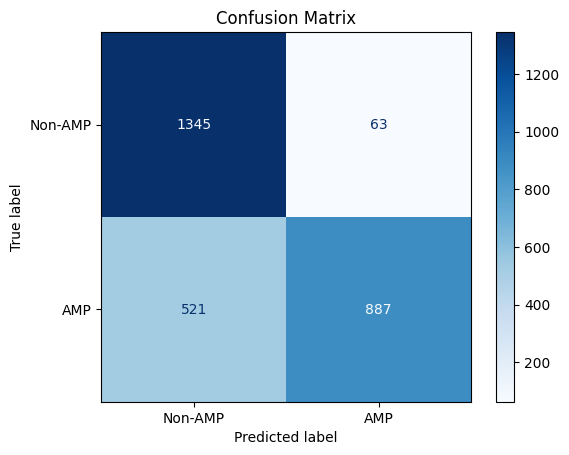

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Generate predictions
predicted_labels = np.argmax(logits, axis=1)

# Compute confusion matrix
cm = confusion_matrix(predictions.label_ids, predicted_labels)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Non-AMP", "AMP"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()